<a href="https://colab.research.google.com/github/andysun-1997/Create-Bell-state/blob/master/Create_Bell_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Summary
*   We use a variational circuit to produce the target state by optimizing circuit parameters
*   Higher number of measurements makes the result more accurate
*   To produce exactly the state |01> + |10>, I think we need to access the final state vector instead of sampling from the final state     





In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install tensorflow-quantum

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
# variables
symbols = sympy.symbols('a b c d')

In [ ]:
# create qubits
q0, q1 = cirq.LineQubit.range(2)

In [78]:
# create variational circuit
def get_var_form(symbols):
  circuit = cirq.Circuit(
    cirq.rx(symbols[0]).on(q0),
    cirq.rx(symbols[1]).on(q1), 
    cirq.ry(symbols[2]).on(q0),
    cirq.ry(symbols[3]).on(q1),
    # Monte Carlo Simulation of Noise
    cirq.bit_flip(p=0.02)(q0),
    cirq.bit_flip(p=0.02)(q1), 
    cirq.CNOT(control=q0, target=q1),
    )
  return circuit

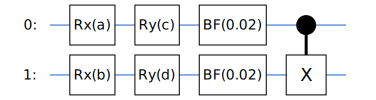

In [ ]:
# Circuit Visualization
circuit = get_var_form(symbols)
SVGCircuit(circuit)

In [77]:
simulator = cirq.Simulator()
#initialize parameters to all 0's
params = [0] * 4
params = tf.convert_to_tensor(
    params, dtype=tf.float32, dtype_hint=None, name=None
)
print('starting parameters:')
print(params)
param0, param1, param2, param3 = 0, 0, 0, 0 
# number of measurements
reps = 1000
# loss function
def loss(params):
  qc = get_var_form(symbols)
  qc.append(cirq.measure(q0, q1, key='result'))
  resolver = cirq.ParamResolver({symbols[0]: params[0], symbols[1]: params[1], symbols[2]: params[2], symbols[3]: params[3]})
  results = simulator.run(qc, resolver, repetitions=reps)
  counter = results.histogram(key='result')
  # loss as sampling probabilities' euclidean distance to (1/2, 1/2)
  loss = (counter[1]/reps - 0.5)**2 + (counter[2]/reps - 0.5)**2
  return loss
l = loss(params)
print('starting loss:' + str(l))

starting parameters:
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
starting loss:0.478442


In [79]:
# optimize
from scipy.optimize import minimize
from scipy import optimize

# Various optimization algorithms
res = minimize(loss, params, method='COBYLA', tol=0.001) ## COBYLA # powell # Nelder-Mead # BFGS
print(res)

     fun: 0.0021409999999999984
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 40
  status: 1
 success: True
       x: array([ 2.09372851,  2.93786202,  1.60129306, -0.20385986])


In [80]:
#verify result
resolver = cirq.ParamResolver({symbols[0]: res.x[0], symbols[1]: res.x[1], symbols[2]: res.x[2], symbols[3]: res.x[3]})
qc = get_var_form(symbols)
qc.append(cirq.measure(q0, q1, key='result'))
results = simulator.run(qc, resolver, repetitions=reps)
counter = results.histogram(key='result')
loss = (counter[1]/reps - 0.5)**2 + (counter[2]/reps - 0.5)**2
print('sampling result: ')
print(counter)
print('loss: ' + str(loss))

# get state vector
qc0 = get_var_form(symbols)
state = simulator.simulate(qc0, resolver).final_state
print('state vector: ')
print(state)

sampling result: 
Counter({1: 487, 2: 470, 0: 23, 3: 20})
loss: 0.0010690000000000018
state vector: 
[ 0.09815069+0.02761446j  0.61148375-0.35114914j -0.6003258 -0.34915677j
 -0.02469578-0.09733628j]
